## Wisconsin Breast Cancer

In [17]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import ensemble
import kmapper as km
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from kmapper import jupyter # Creates custom CSS full-size Jupyter screen
import aux

In [56]:
# Data - the Wisconsin Breast Cancer Dataset
# https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
df = pd.read_csv("breast-cancer.csv")
feature_names = [c for c in df.columns if c not in ["id", "diagnosis"]]
df["diagnosis"] = df["diagnosis"].apply(lambda x: 1 if x == "M" else 0)
X = np.array(df[feature_names].fillna(0))
y = np.array(df["diagnosis"])

In [57]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. 

In [4]:
X.shape

(569, 31)

In [5]:
feature_names

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst',
 'Unnamed: 32']

### PCA

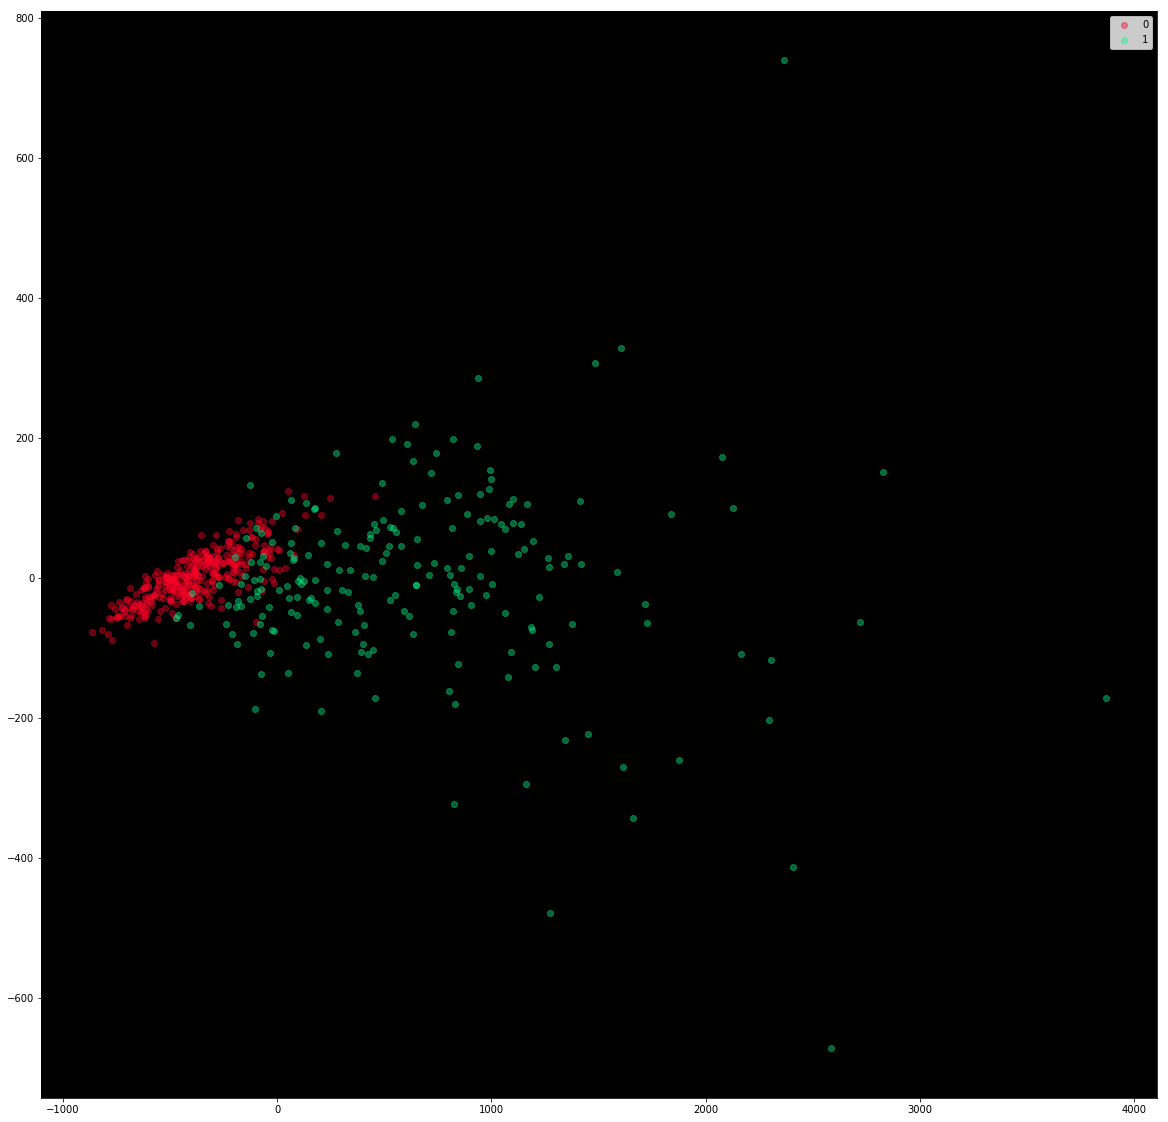

In [42]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
aux.visualize_scatter(principalComponents, y)

### t-SNE

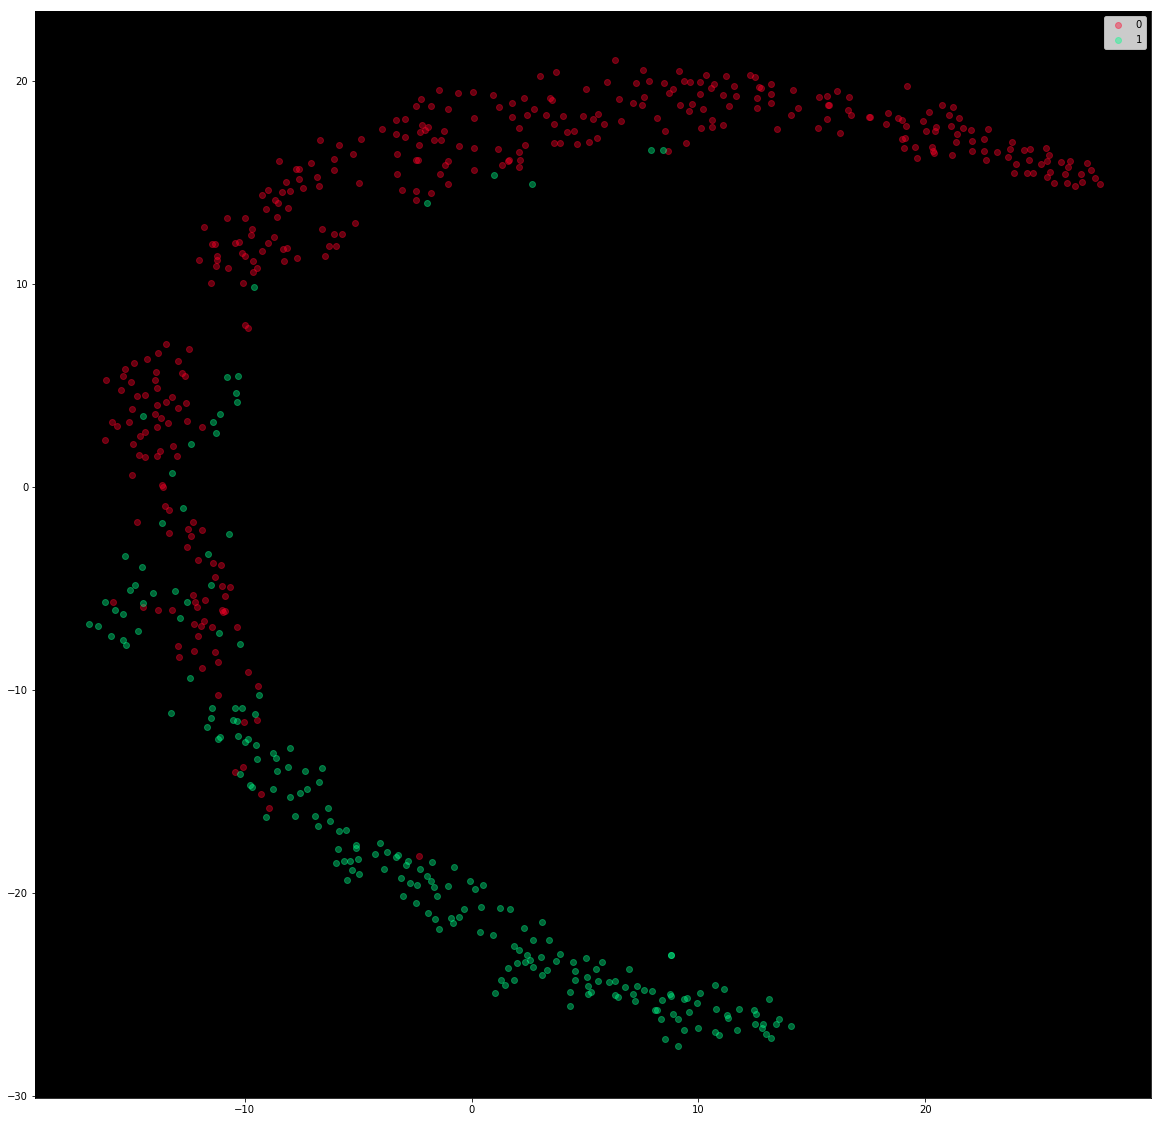

In [21]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(X)
aux.visualize_scatter(tsne_result, y)

### UMAP

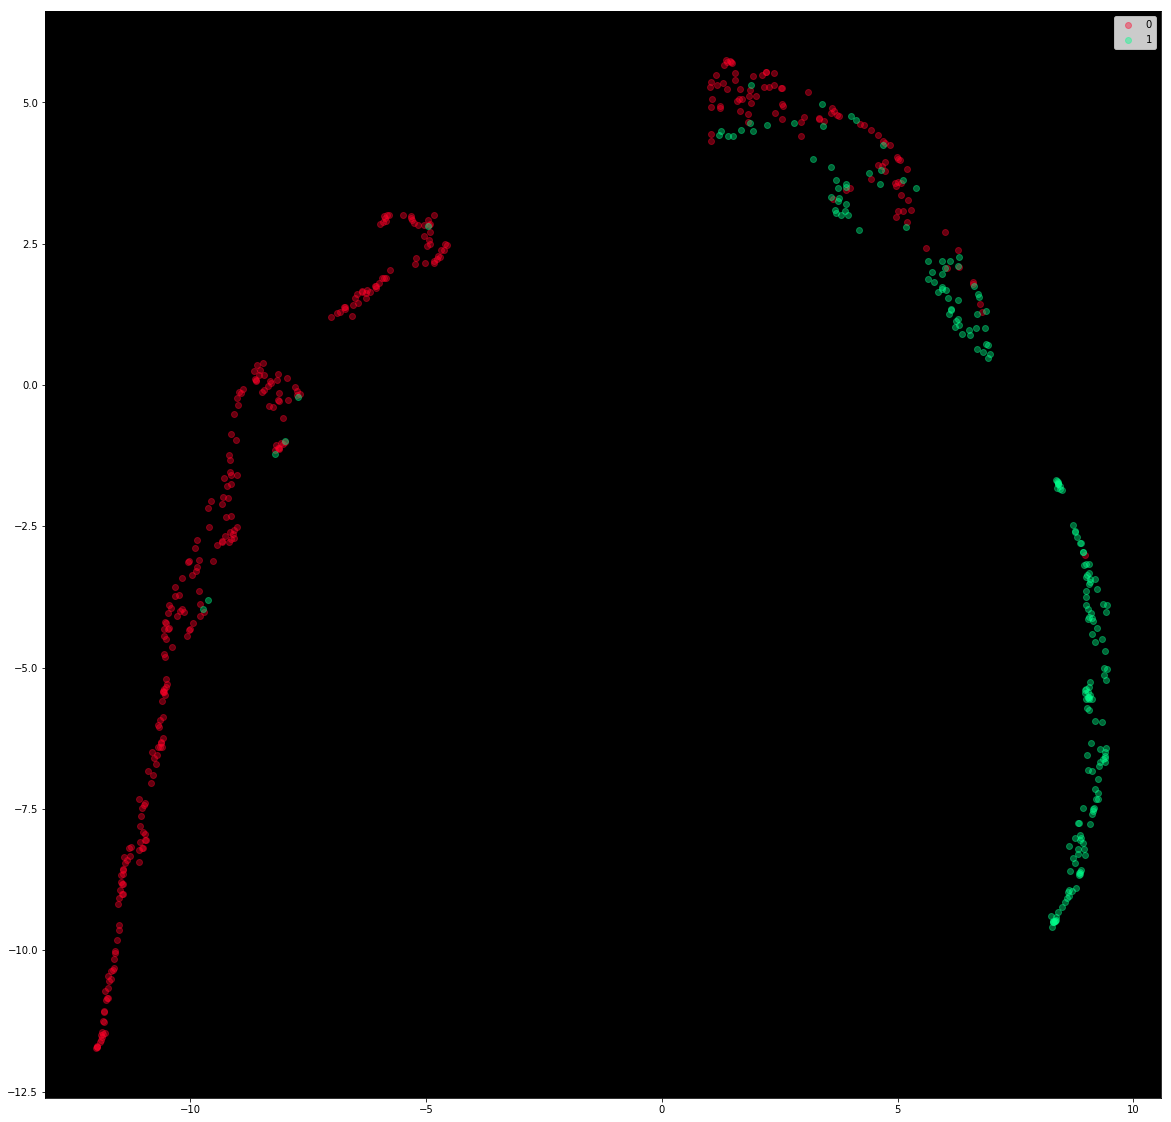

In [16]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
aux.visualize_scatter(embedding, y)

### Mapper

In [50]:
# Create a custom 1-D lens with Isolation Forest, which return the anomaly score of each sample.
# This makes biological sense since cancer cells are anomalous.
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Create another 1-D lens with L2-norm. 
#Disperse the data, as opposed to clustering many points together.
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to get a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Define the simplicial complex
scomplex = mapper.map(lens,
                      X,
                      nr_cubes=130,
                      overlap_perc=0.70,
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))


In [51]:
target_names = [0,1]

In [52]:
html = mapper.visualize(scomplex,
                        path_html="breast_cancer.html",
                        title="Cancer Data",
                        custom_tooltips=np.array([target_names[ys] for ys in y]),
                        color_function=y)


In [55]:
jupyter.display("breast_cancer.html")